In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [10]:
# Load the cleaned datasets
true_data = pd.read_csv('Cleaned_True_Data.csv')
fake_data = pd.read_csv('Cleaned_False_Data.csv')

# Add a label column to distinguish between true and fake news
true_data['label'] = 1
fake_data['label'] = 0

# Combine the datasets
data = pd.concat([true_data, fake_data], ignore_index=True)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display basic information
display(data.head())
display(data.info())

,Article Title,Content,Category,Publication Date,label
0,THE END OF CROOKED HILLARY’S POLITICAL CAREER:...,A true story of how Americans rejected sociali...,politics,NaN,0
1,"Trial against Guatemalan president's brother, ...",GUATEMALA CITY (Reuters) - A fraud trial again...,worldnews,2017-08-30,1
2,North Korean foreign minister heads to Cuba,HAVANA (Reuters) - North Korea s foreign minis...,worldnews,2017-11-20,1
3,Lindsey Graham Calls Out His Own Party; Says ...,S.C. Senator Lindsey Graham has been a shining...,News,2017-01-08,0
4,Illinois governor rejects school funding legis...,CHICAGO (Reuters) - Illinois Governor Bruce Ra...,politicsNews,2017-08-01,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Article Title     44689 non-null  object
 1   Content           44689 non-null  object
 2   Category          44689 non-null  object
 3   Publication Date  33079 non-null  object
 4   label             44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


None

In [11]:
# Using TF-IDF for feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['Content']).toarray()
y = data['label'].values

# Alternatively, using tokenization for neural networks
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Content'])
X = tokenizer.texts_to_sequences(data['Content'])
X = pad_sequences(X, maxlen=500)
y = to_categorical(data['label'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4960 - loss: 223.6070 - val_accuracy: 0.4809 - val_loss: 0.8524
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5057 - loss: 3.0020 - val_accuracy: 0.5319 - val_loss: 0.6913
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5115 - loss: 1.1515 - val_accuracy: 0.5319 - val_loss: 0.6914
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5137 - loss: 0.8817 - val_accuracy: 0.5319 - val_loss: 0.6914
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5218 - loss: 0.8249 - val_accuracy: 0.5319 - val_loss: 0.6913
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5188 - loss: 0.7729 - val_accuracy: 0.5319 - val_loss: 0.6914
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5225 - loss: 0.7311 - val_accuracy: 0.5319 - val_loss: 0.6914
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5144 - loss: 0.7470 - val_accuracy: 

419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
Accuracy: 0.529723278884165


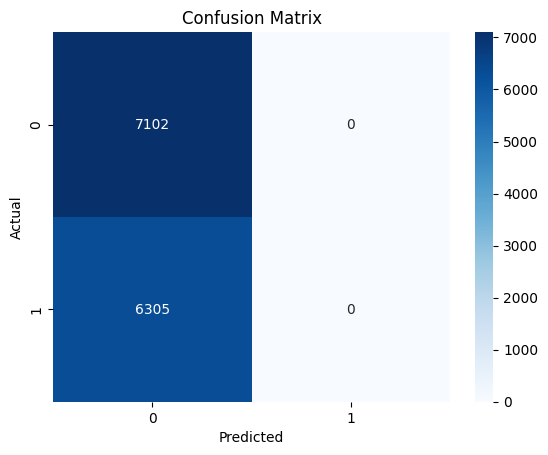

              precision    recall  f1-score   support

           0       0.53      1.00      0.69      7102
           1       0.00      0.00      0.00      6305

    accuracy                           0.53     13407
   macro avg       0.26      0.50      0.35     13407
weighted avg       0.28      0.53      0.37     13407



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [18]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test_classes, y_pred_classes))

In [19]:
model.save('fake_news_detection_model.h5')

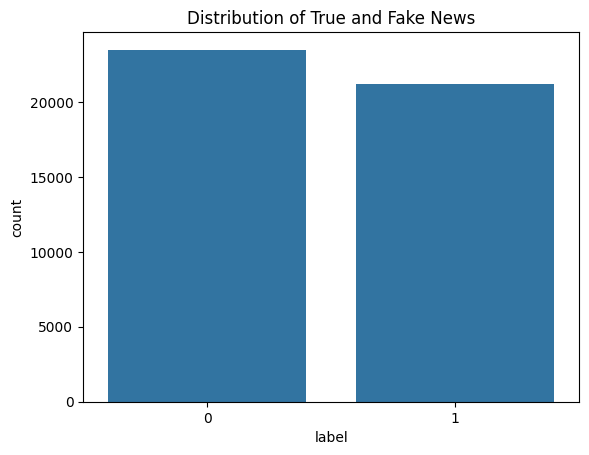

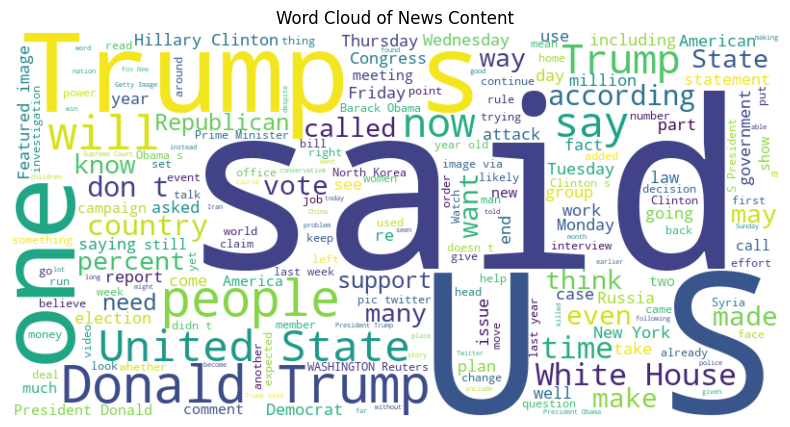

In [9]:
# Distribution of true and fake news
sns.countplot(x='label', data=data)
plt.title('Distribution of True and Fake News')
plt.show()

# Word Cloud (optional)
from wordcloud import WordCloud

text = ' '.join(data['Content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Content')
plt.show()